In [1]:
# LOAD LIBRARY
import pandas as pd
from supabase import create_client, Client
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# LOAD CONNECTION TO SUPABASE
load_dotenv()
supabase_url = os.getenv("SUPABASE_URL")
supabase_key = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

In [16]:
# GET DATABASE 
response = supabase.table("feedback_ir").select("id, created_at, user, query, result1, result2").execute()
data = response.data


In [17]:
df = pd.DataFrame(data)
df = df[df['result2'].notna()]
df.head()

,id,created_at,user,query,result1,result2
28,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,"[{'suraId': 36, 'verseID': 15, 'indoText': 'Me...","[{'suraId': 36, 'verseID': 15, 'indoText': 'Me..."
29,35,2025-06-09T07:08:13.390229+00:00,337,apa itu syubhat,"[{'suraId': 2, 'verseID': 184, 'indoText': '(Y...","[{'suraId': 2, 'verseID': 184, 'indoText': '(Y..."
30,36,2025-06-09T07:13:55.973017+00:00,337,apa itu jalan yang lurus,"[{'suraId': 34, 'verseID': 30, 'indoText': 'Ka...","[{'suraId': 34, 'verseID': 30, 'indoText': 'Ka..."
31,37,2025-06-09T07:34:40.721742+00:00,337,apa itu tuhan yang maha esa,"[{'suraId': 36, 'verseID': 15, 'indoText': 'Me...","[{'suraId': 36, 'verseID': 15, 'indoText': 'Me..."
32,38,2025-06-09T07:38:19.455802+00:00,337,"hukum bagi orang yang berdusta, berbohong, men...","[{'suraId': 48, 'verseID': 25, 'indoText': 'Me...","[{'suraId': 48, 'verseID': 25, 'indoText': 'Me..."


In [19]:
def parse_result(val):
    if isinstance(val, str):
        try:
            return json.loads(val)
        except:
            return []
    elif isinstance(val, list):
        return val
    return []

df['result1'] = df['result1'].apply(parse_result)
df['result2'] = df['result2'].apply(parse_result)

# 2. Gabungkan dua list per baris menjadi satu list of tuple agar bisa diexplode sejajar
df['paired'] = df.apply(lambda row: list(zip(row['result1'], row['result2'])), axis=1)

# 3. Explode paired (jadi per baris mewakili pasangan result1 & result2)
df_exploded = df.explode('paired').reset_index(drop=True)

# 4. Pisahkan tuple ke dua kolom
df_exploded[['r1', 'r2']] = pd.DataFrame(df_exploded['paired'].tolist(), index=df_exploded.index)
 
# 5. Normalize dict r1 dan r2 menjadi kolom
r1_df = pd.json_normalize(df_exploded['r1']).add_prefix('r1_')
r2_df = pd.json_normalize(df_exploded['r2']).add_prefix('r2_')

df_final = pd.concat([df_exploded.drop(columns=['result1', 'result2', 'paired', 'r1', 'r2']),
                      r1_df, r2_df], axis=1)

df_final.head()


,id,created_at,user,query,combined,r1_suraId,r1_verseID,r1_indoText,r1_score,r1_is_relevan,r2_suraId,r2_verseID,r2_indoText,r2_score,r2_is_relevan
0,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,"[({'suraId': 36, 'verseID': 15, 'indoText': 'M...",36,15,"Mereka (penduduk negeri) menjawab, “Kamu ini h...",0.825424,False,36,15,"Mereka (penduduk negeri) menjawab, “Kamu ini h...",0.825424,False
1,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,"[({'suraId': 36, 'verseID': 15, 'indoText': 'M...",112,1,"Katakanlah (Muhammad), “Dialah Allah, Yang Mah...",0.767163,True,112,1,"Katakanlah (Muhammad), “Dialah Allah, Yang Mah...",0.767163,False
2,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,"[({'suraId': 36, 'verseID': 15, 'indoText': 'M...",7,67,"Dia (Hud) menjawab, “Wahai kaumku! Bukan aku k...",0.716270,False,7,67,"Dia (Hud) menjawab, “Wahai kaumku! Bukan aku k...",0.716270,False
3,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,"[({'suraId': 36, 'verseID': 15, 'indoText': 'M...",53,21,Apakah (pantas) untuk kamu yang laki-laki dan ...,0.710502,False,53,21,Apakah (pantas) untuk kamu yang laki-laki dan ...,0.710502,False
4,34,2025-06-09T07:07:01.182552+00:00,337,apa itu tuhan yang maha esa,"[({'suraId': 36, 'verseID': 15, 'indoText': 'M...",19,4,"Dia (Zakaria) berkata, “Ya Tuhanku, sungguh tu...",0.707112,False,19,4,"Dia (Zakaria) berkata, “Ya Tuhanku, sungguh tu...",0.707112,False


In [ ]:
df_final.to_csv('hasil_pengujian.csv', index=False)

In [47]:
# Inisialisasi list hasil
results = []

# Hitung jumlah grup (jumlah query) = total baris / 15
num_queries = len(df_final) // 15

# Loop per query (setiap 15 baris)
for i in range(num_queries):
    start = i * 15
    end = start + 15
    group = df_final.iloc[start:end]

    # Total relevan ground truth (diambil dari seluruh 15 baris)
    total_r1_rel = group['r1_is_relevan'].sum()
    total_r2_rel = group['r2_is_relevan'].sum()

    # Untuk k in [5, 10, 15]
    for k in [5, 10, 15]:
        # Ambil top-k baris
        topk = group.iloc[:k]
        
        # Hitung relevan di top-k
        r1_rel_k = topk['r1_is_relevan'].sum()
        r2_rel_k = topk['r2_is_relevan'].sum()

        # Hitung precision dan recall
        r1_precision = r1_rel_k / k
        r2_precision = r2_rel_k / k

        r1_recall = r1_rel_k / total_r1_rel if total_r1_rel > 0 else 0
        r2_recall = r2_rel_k / total_r2_rel if total_r2_rel > 0 else 0

        # Simpan hasil
        results.append({
            'query_id': i,
            'k': k,
            'r1_precision': r1_precision,
            'r1_recall': r1_recall,
            'r2_precision': r2_precision,
            'r2_recall': r2_recall,
            'total_r1_relevant': total_r1_rel,
            'total_r2_relevant': total_r2_rel,
        })

# Buat DataFrame hasil
df_metrics = pd.DataFrame(results)
df_metrics


,query_id,k,r1_precision,r1_recall,r2_precision,r2_recall,total_r1_relevant,total_r2_relevant
0,0,5,0.200000,1.00,0.000000,0.000000,1,0
1,0,10,0.100000,1.00,0.000000,0.000000,1,0
2,0,15,0.066667,1.00,0.000000,0.000000,1,0
3,1,5,0.000000,0.00,0.000000,0.000000,0,0
4,1,10,0.000000,0.00,0.000000,0.000000,0,0
5,1,15,0.000000,0.00,0.000000,0.000000,0,0
6,2,5,0.000000,0.00,0.000000,0.000000,0,0
7,2,10,0.000000,0.00,0.000000,0.000000,0,0
8,2,15,0.000000,0.00,0.000000,0.000000,0,0
9,3,5,0.200000,1.00,0.200000,0.250000,1,4


In [48]:
# Fungsi untuk menghitung F-beta score
# β = 1 untuk F1
def fbeta(p, r, beta=1.0):
    if p + r == 0:
        return 0.0
    beta_sq = beta ** 2
    return (1 + beta_sq) * p * r / (beta_sq * p + r)

# Terapkan ke df_metrics
df_metrics['r1_f1'] = df_metrics.apply(lambda row: fbeta(row['r1_precision'], row['r1_recall'], beta=1), axis=1)
df_metrics['r2_f1'] = df_metrics.apply(lambda row: fbeta(row['r2_precision'], row['r2_recall'], beta=1), axis=1)


In [49]:
query_ids_to_remove = [0, 1, 4, 6, 8, 12, 13, 14]
df_metrics = df_metrics[~df_metrics['query_id'].isin(query_ids_to_remove)]
df_metrics.reset_index(drop=True, inplace=True)

In [50]:
df_metrics

,query_id,k,r1_precision,r1_recall,r2_precision,r2_recall,total_r1_relevant,total_r2_relevant,r1_f1,r2_f1
0,2,5,0.000000,0.00,0.000000,0.000000,0,0,0.000000,0.000000
1,2,10,0.000000,0.00,0.000000,0.000000,0,0,0.000000,0.000000
2,2,15,0.000000,0.00,0.000000,0.000000,0,0,0.000000,0.000000
3,3,5,0.200000,1.00,0.200000,0.250000,1,4,0.333333,0.222222
4,3,10,0.100000,1.00,0.300000,0.750000,1,4,0.181818,0.428571
5,3,15,0.066667,1.00,0.266667,1.000000,1,4,0.125000,0.421053
6,5,5,0.200000,1.00,0.400000,0.666667,1,3,0.333333,0.500000
7,5,10,0.100000,1.00,0.200000,0.666667,1,3,0.181818,0.307692
8,5,15,0.066667,1.00,0.200000,1.000000,1,3,0.125000,0.333333
9,7,5,0.200000,1.00,0.400000,0.333333,1,6,0.333333,0.363636


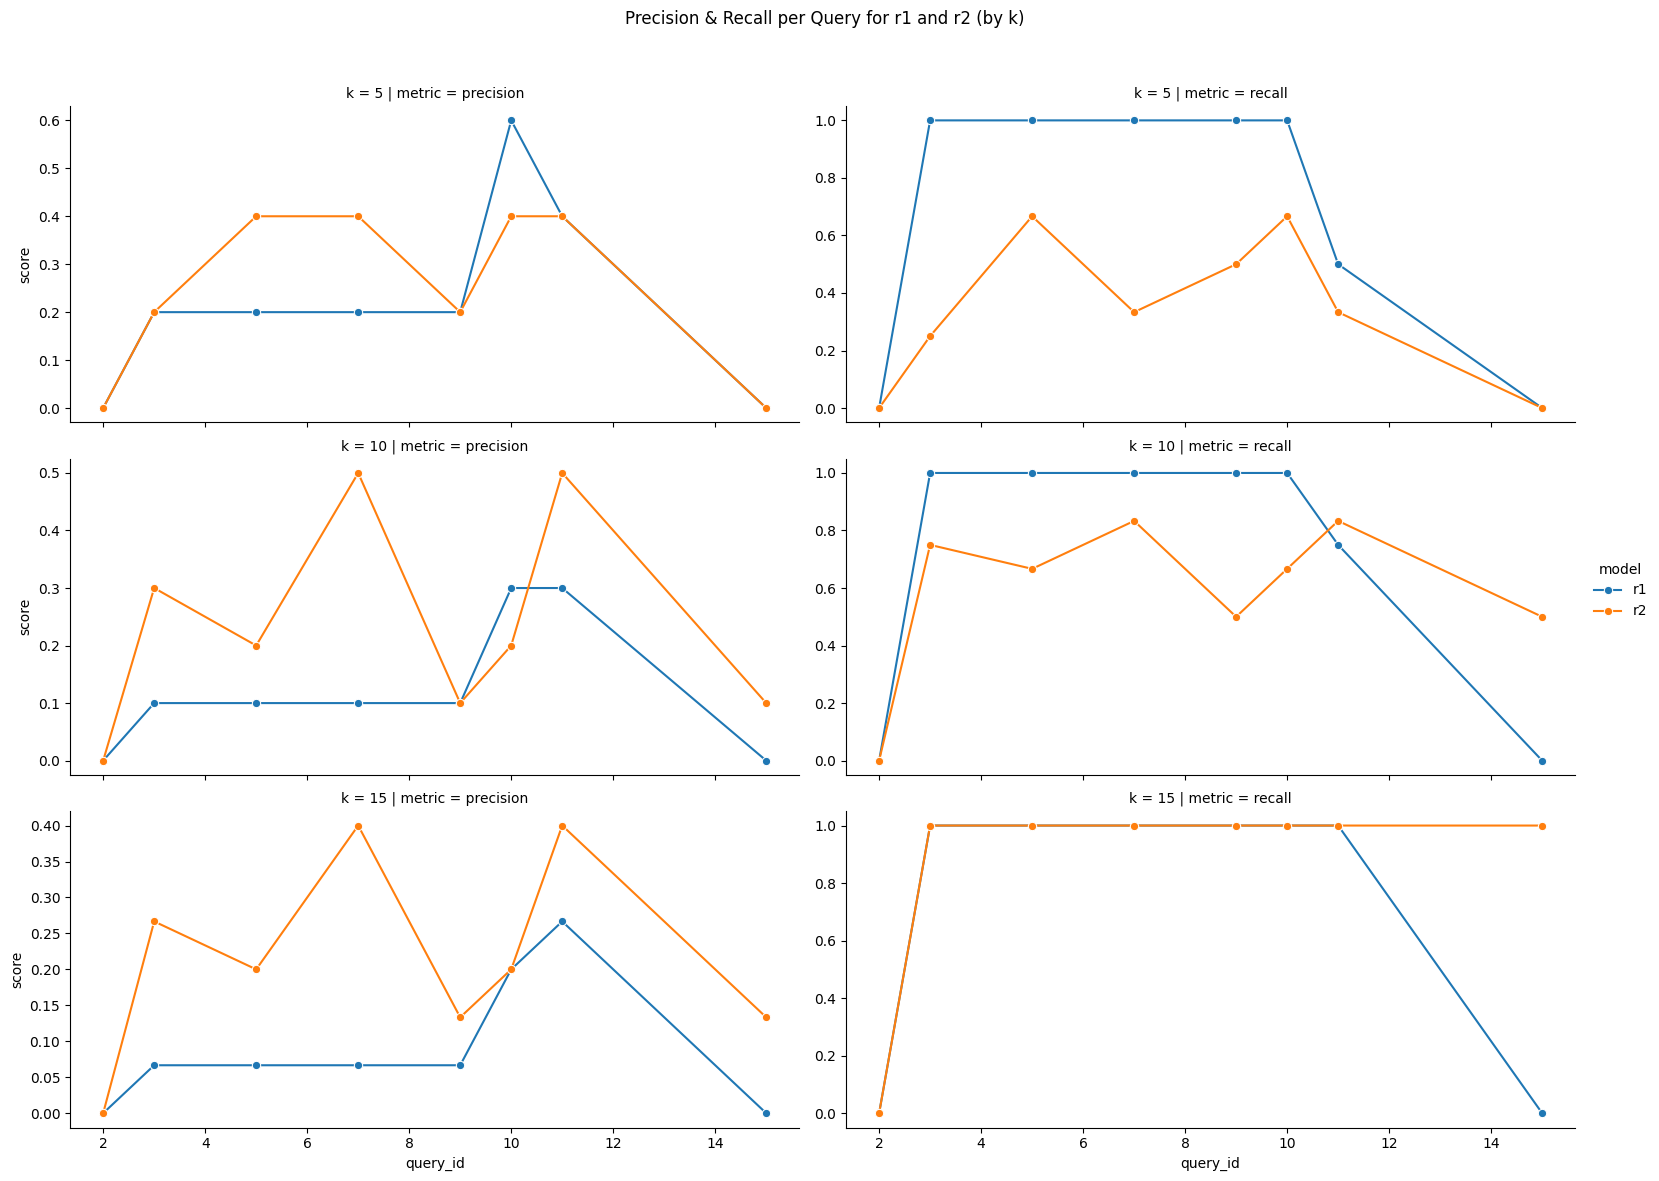

In [51]:
# Visualisasi Precision dan Recall per Query untuk r1 dan r2
# Ubah df_metrics menjadi format long agar mudah divisualisasikan
df_long = pd.melt(
    df_metrics,
    id_vars=['query_id', 'k'],
    value_vars=['r1_precision', 'r1_recall', 'r2_precision', 'r2_recall'],
    var_name='metric_model',
    value_name='score'
)

# Pisahkan metric_model menjadi dua kolom: metric (precision/recall) dan model (r1/r2)
df_long['metric'] = df_long['metric_model'].apply(lambda x: x.split('_')[1])
df_long['model'] = df_long['metric_model'].apply(lambda x: x.split('_')[0])

# Plot
g = sns.FacetGrid(df_long, col="metric", row="k", hue="model", height=4, aspect=2, sharey=False)
g.map(sns.lineplot, "query_id", "score", marker="o")
g.add_legend()

# Tambahkan judul global
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Precision & Recall per Query for r1 and r2 (by k)")

plt.show()


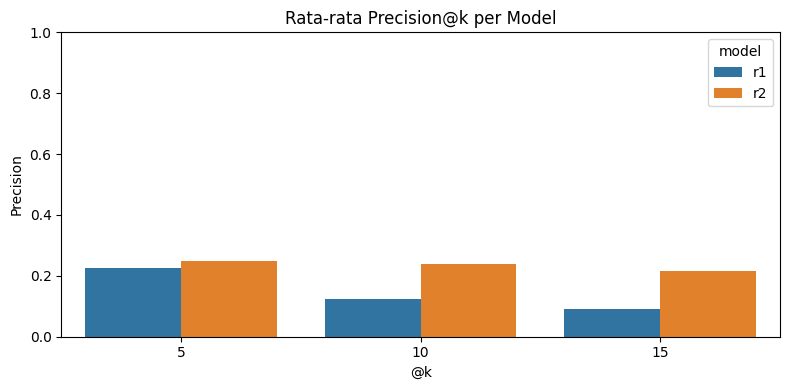

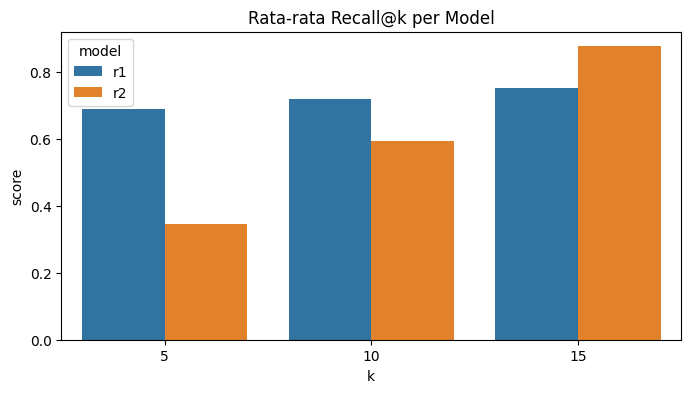

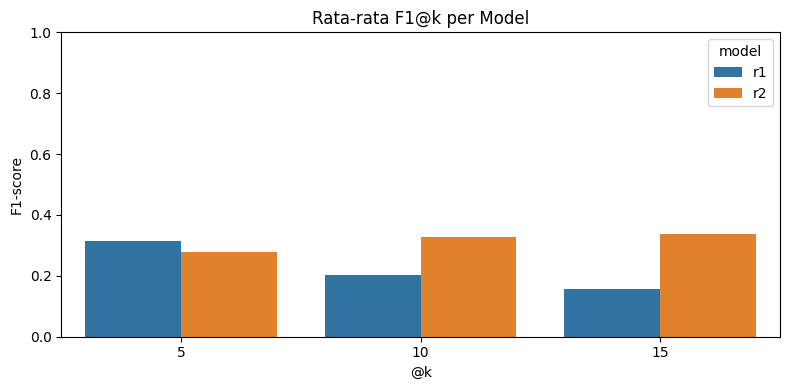

In [52]:
# Visualisasi Rata-rata Precision dan Recall per Model (r1 dan r2)
# Ringkas rata-rata precision dan recall per model untuk setiap k
summary_df = df_metrics.groupby('k').agg({
    'r1_precision': 'mean',
    'r2_precision': 'mean',
    'r1_recall': 'mean',
    'r2_recall': 'mean',
    'r1_f1': 'mean',         
    'r2_f1': 'mean'
}).reset_index()

# Ubah jadi long format untuk mudah plotting
precision_long = summary_df[['k', 'r1_precision', 'r2_precision']].melt(id_vars='k', 
    var_name='model', value_name='score')
precision_long['model'] = precision_long['model'].str.replace('_precision', '')

recall_long = summary_df[['k', 'r1_recall', 'r2_recall']].melt(id_vars='k', 
    var_name='model', value_name='score')
recall_long['model'] = recall_long['model'].str.replace('_recall', '')

f1_long = summary_df[['k', 'r1_f1', 'r2_f1']].melt(id_vars='k', 
    var_name='model', value_name='score')
f1_long['model'] = f1_long['model'].str.replace('_f1', '')

# Plot Precision
plt.figure(figsize=(8, 4))
sns.barplot(data=precision_long, x='k', y='score', hue='model')
plt.title('Rata-rata Precision@k per Model')
plt.ylabel('Precision')
plt.xlabel('@k')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot Recall
plt.figure(figsize=(8, 4))
sns.barplot(data=recall_long, x='k', y='score', hue='model')
plt.title('Rata-rata Recall@k per Model')

# Plot F1
plt.figure(figsize=(8, 4))
sns.barplot(data=f1_long, x='k', y='score', hue='model')
plt.title('Rata-rata F1@k per Model')
plt.ylabel('F1-score')
plt.xlabel('@k')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

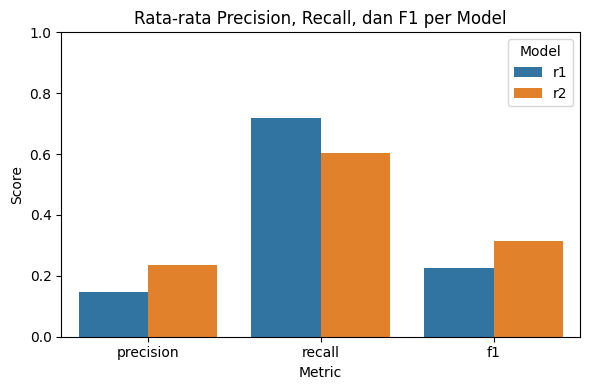

In [53]:
# Visualisasi Rata-rata Precision dan Recall per Model (r1 dan r2)

# Buat DataFrame dari hasil rata-rata (termasuk F1)
avg_df = pd.DataFrame({
    'model': ['r1', 'r2'],
    'precision': [df_metrics['r1_precision'].mean(), df_metrics['r2_precision'].mean()],
    'recall': [df_metrics['r1_recall'].mean(), df_metrics['r2_recall'].mean()],
    'f1': [df_metrics['r1_f1'].mean(), df_metrics['r2_f1'].mean()]
})

# Ubah ke format long untuk plotting
avg_df_long = pd.melt(avg_df, id_vars='model', var_name='metric', value_name='score')

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_df_long, x='metric', y='score', hue='model')
plt.title('Rata-rata Precision, Recall, dan F1 per Model')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [54]:
df_long

,query_id,k,metric_model,score,metric,model
0,2,5,r1_precision,0.000000,precision,r1
1,2,10,r1_precision,0.000000,precision,r1
2,2,15,r1_precision,0.000000,precision,r1
3,3,5,r1_precision,0.200000,precision,r1
4,3,10,r1_precision,0.100000,precision,r1
...,...,...,...,...,...,...
91,11,10,r2_recall,0.833333,recall,r2
92,11,15,r2_recall,1.000000,recall,r2
93,15,5,r2_recall,0.000000,recall,r2
94,15,10,r2_recall,0.500000,recall,r2


In [55]:
summary_df

,k,r1_precision,r2_precision,r1_recall,r2_recall,r1_f1,r2_f1
0,5,0.225000,0.250000,0.68750,0.34375,0.315972,0.279401
1,10,0.125000,0.237500,0.71875,0.59375,0.202173,0.328411
2,15,0.091667,0.216667,0.75000,0.87500,0.156798,0.337646


In [56]:
avg_df

,model,precision,recall,f1
0,r1,0.147222,0.718750,0.224981
1,r2,0.234722,0.604167,0.315153


In [57]:
# Tabel Precision
df_precision = df_metrics[['query_id', 'k', 'r1_precision', 'r2_precision']].copy()

# Tabel Recall
df_recall = df_metrics[['query_id', 'k', 'r1_recall', 'r2_recall']].copy()

# Tabel F1-score
df_f1 = df_metrics[['query_id', 'k', 'r1_f1', 'r2_f1']].copy()

# Opsional: tampilkan semua
print("Precision Table:\n", df_precision.head())
print("\nRecall Table:\n", df_recall.head())
print("\nF1 Table:\n", df_f1.head())


Precision Table:
    query_id   k  r1_precision  r2_precision
0         2   5           0.0           0.0
1         2  10           0.0           0.0
2         2  15           0.0           0.0
3         3   5           0.2           0.2
4         3  10           0.1           0.3

Recall Table:
    query_id   k  r1_recall  r2_recall
0         2   5        0.0       0.00
1         2  10        0.0       0.00
2         2  15        0.0       0.00
3         3   5        1.0       0.25
4         3  10        1.0       0.75

F1 Table:
    query_id   k     r1_f1     r2_f1
0         2   5  0.000000  0.000000
1         2  10  0.000000  0.000000
2         2  15  0.000000  0.000000
3         3   5  0.333333  0.222222
4         3  10  0.181818  0.428571


In [58]:
# Filter precision dan pivot
precision_pivot = df_metrics.pivot_table(
    index='query_id',
    columns='k',
    values=['r1_precision', 'r2_precision']
)

# Rapikan nama kolom
precision_pivot.columns = [f"{model}@{k}" for model, k in precision_pivot.columns]
precision_pivot = precision_pivot.reset_index()

# Opsional: tambahkan kueri jika kamu punya kolom query
precision_pivot = precision_pivot.merge(df_metrics[['query_id']].drop_duplicates(), on='query_id', how='left')


In [59]:
# Filter recall dan pivot
recall_pivot = df_metrics.pivot_table(
    index='query_id',
    columns='k',
    values=['r1_recall', 'r2_recall']
)

recall_pivot.columns = [f"{model}@{k}" for model, k in recall_pivot.columns]
recall_pivot = recall_pivot.reset_index()
recall_pivot = recall_pivot.merge(df_metrics[['query_id']].drop_duplicates(), on='query_id', how='left')


In [60]:
# Filter f1 dan pivot
f1_pivot = df_metrics.pivot_table(
    index='query_id',
    columns='k',
    values=['r1_f1', 'r2_f1']
)

f1_pivot.columns = [f"{model}@{k}" for model, k in f1_pivot.columns]
f1_pivot = f1_pivot.reset_index()
f1_pivot = f1_pivot.merge(df_metrics[['query_id']].drop_duplicates(), on='query_id', how='left')



In [44]:
precision_pivot.to_csv("tabel_precision.csv", index=False)
recall_pivot.to_csv("tabel_recall.csv", index=False)
recall_pivot.to_csv("tabel_f1.csv", index=False)